Raw data shape: (100000, 18)

First 5 rows:
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794 

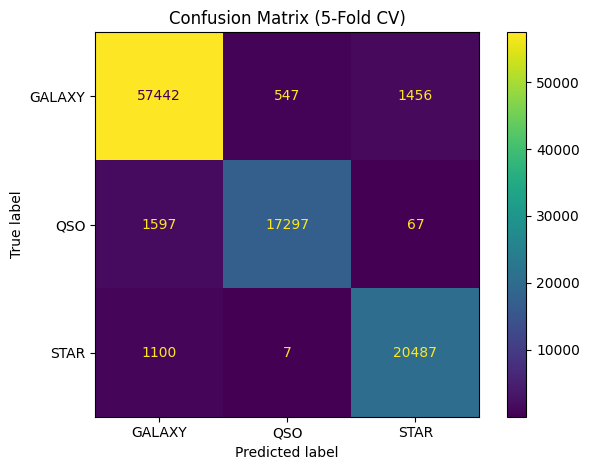


=== RANDOM FOREST PERFORMANCE ===
Accuracy: 0.9776

Classification report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       0.98      1.00      0.99      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000

Confusion Matrix (raw counts):
[[11724    98    67]
 [  277  3515     0]
 [    6     0  4313]]


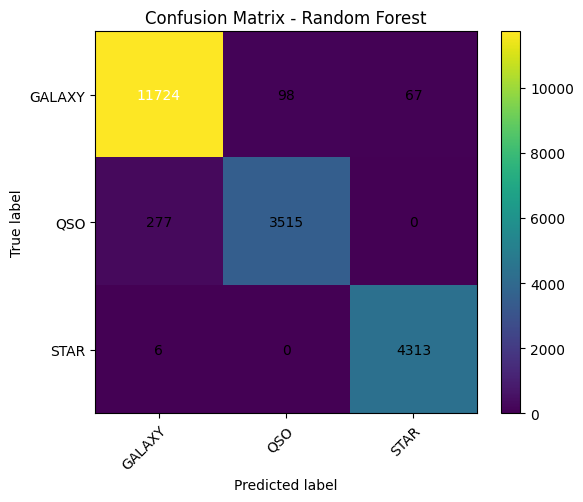


Top 10 most important features:
     feature  importance
7   redshift    0.356128
13       g_i    0.067918
10       r_i    0.066410
12       u_r    0.062077
16       PC2    0.053693
21       PC7    0.053029
17       PC3    0.052909
14       r_z    0.045665
9        g_r    0.042323
8        u_g    0.036730

Number of misclassified samples: 448

Five misclassified examples:
            alpha      delta         u         g         r         i  \
58831  135.977254  22.971291  26.28650  22.29410  20.46461  19.27920   
29204   22.183747   4.450217  23.54034  22.08017  21.74554  21.58752   
22850  130.762563  23.498424  22.09398  21.70409  21.60573  21.72319   
95012    6.871748   2.233591  22.58970  22.08010  21.83377  21.73608   
17797  189.575880  56.180069  22.45733  23.30622  21.37446  20.34853   

              z  redshift      u_g      g_r      r_i      i_z      u_r  \
58831  18.78435  0.000000  3.99240  1.82949  1.18541  0.49485  5.82189   
29204  21.36760  1.786434  1.46017  0.33463

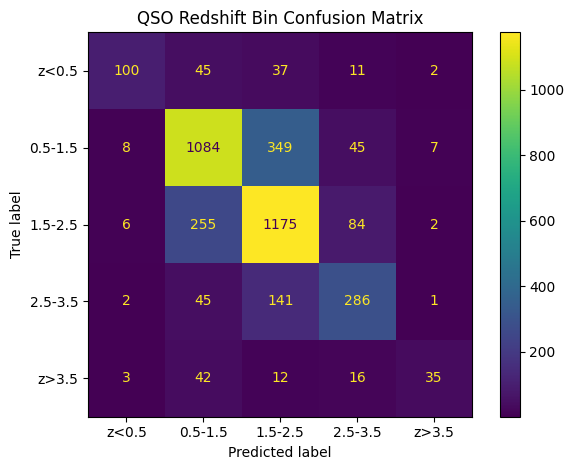

Saved: qso_redshift_bin_predictions.csv

Class proportion table (overall / train / test):
        overall_prop  train_prop  test_prop
class                                      
GALAXY       0.59445    0.594450    0.59445
STAR         0.21594    0.215938    0.21595
QSO          0.18961    0.189612    0.18960

Misclassified samples (selected columns):
              u         g         r         i         z       alpha  \
58831  26.28650  22.29410  20.46461  19.27920  18.78435  135.977254   
29204  23.54034  22.08017  21.74554  21.58752  21.36760   22.183747   
22850  22.09398  21.70409  21.60573  21.72319  21.26084  130.762563   
95012  22.58970  22.08010  21.83377  21.73608  21.92675    6.871748   
17797  22.45733  23.30622  21.37446  20.34853  19.48138  189.575880   

           delta true_label pred_label  
58831  22.971291     GALAXY       STAR  
29204   4.450217     GALAXY        QSO  
22850  23.498424     GALAXY        QSO  
95012   2.233591     GALAXY        QSO  
17797  56.18006

In [ ]:
"""
Star / Galaxy / QSO Classification using Supervised Learning

- Dataset: star_classification.csv (e.g., SDSS-based catalog)
- Goal: Predict the object class (STAR, GALAXY, QSO) from photometric & related features
- Model: RandomForestClassifier (multiclass classification)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)


# 1. CONFIG & DATA LOADING

DATA_PATH = Path(r"C:\Users\cenke\star_classification.csv")  
df = pd.read_csv(DATA_PATH)

print("Raw data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nClass distribution:")
print(df["class"].value_counts())
print("\nAny missing values?")
print(df.isna().sum())

# 2. BASIC CLEANING & FEATURE SETUP

ID_COLUMNS = [
    "obj_ID",
    "spec_obj_ID",
    "run_ID",
    "rerun_ID",
    "cam_col",
    "field_ID",
    "plate",
    "MJD",
    "fiber_ID",
]

data = df.copy()
data = data.drop(columns=ID_COLUMNS)
data = data.dropna()

print("\nCleaned data shape:", data.shape)

TARGET_COL = "class"
y = data[TARGET_COL]
X = data.drop(columns=[TARGET_COL])

# 3. COLOR INDICES (engineered features) 
X["u_g"] = X["u"] - X["g"]
X["g_r"] = X["g"] - X["r"]
X["r_i"] = X["r"] - X["i"]
X["i_z"] = X["i"] - X["z"]
X["u_r"] = X["u"] - X["r"]
X["g_i"] = X["g"] - X["i"]
X["r_z"] = X["r"] - X["z"]

print("\nFeatures:")
print(X.columns.tolist())

# 4. TRAIN / TEST SPLIT (SUPERVISION)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)

# 5. PCA FEATURES 
pca_features = X_train.columns.tolist()  
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[pca_features])
X_test_scaled  = scaler.transform(X_test[pca_features])

pca = PCA(n_components=8, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

for k in range(X_train_pca.shape[1]):
    X_train[f"PC{k+1}"] = X_train_pca[:, k]
    X_test[f"PC{k+1}"]  = X_test_pca[:, k]

print("\nExplained variance ratio (PCA):")
for i, ev in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {ev:.4f}")

# 6. MODEL: RANDOM FOREST

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  
)

# 7. CROSS-VALIDATION 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8, random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

y_cv_pred = cross_val_predict(cv_pipe, X, y, cv=cv, n_jobs=-1)

print("\n=== 5-Fold CV PERFORMANCE (full dataset) ===")
print(classification_report(y, y_cv_pred))

cm_cv = confusion_matrix(y, y_cv_pred, labels=np.unique(y))
ConfusionMatrixDisplay(cm_cv, display_labels=np.unique(y)).plot(values_format="d")
plt.title("Confusion Matrix (5-Fold CV)")
plt.tight_layout()
plt.show()

rf_model.fit(X_train, y_train)

# 8. EVALUATION

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n=== RANDOM FOREST PERFORMANCE ===")
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
print("Confusion Matrix (raw counts):")
print(cm)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix - Random Forest")
plt.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(rf_model.classes_)))
ax.set_yticks(np.arange(len(rf_model.classes_)))
ax.set_xticklabels(rf_model.classes_)
ax.set_yticklabels(rf_model.classes_)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.savefig("confusion_matrix_rf.png", dpi=300)
plt.show()

# 9. FEATURE IMPORTANCE (INSIGHTS)

importances = rf_model.feature_importances_

if hasattr(rf_model, "feature_names_in_"):
    feature_names = rf_model.feature_names_in_
else:
    feature_names = X_train.columns  

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 10 most important features:")
print(fi_df.head(10))


# 10. FIND MISCLASSIFIED SAMPLES

results_df = X_test.copy()
results_df["true_label"] = y_test.values
results_df["pred_label"] = y_pred
results_df["correct"] = results_df["true_label"] == results_df["pred_label"]

mistakes = results_df[~results_df["correct"]]

print("\nNumber of misclassified samples:", len(mistakes))

mistakes_head = mistakes.head(5)
print("\nFive misclassified examples:")
print(mistakes_head)

mistakes_head.to_csv("misclassified_samples_top5.csv", index=False)
print("\nSaved 5 misclassified samples to 'misclassified_samples_top5.csv'")

results_df.to_csv("test_predictions_with_labels.csv", index=False)
print("Saved full test predictions to 'test_predictions_with_labels.csv'")

# 11. UNSUPERVISED: cluster subtypes within each major class 
cluster_cols = ["u","g","r","i","z","u_g","g_r","r_i","i_z","u_r","g_i","r_z"]

cluster_df = data.copy()
cluster_df["u_g"] = cluster_df["u"] - cluster_df["g"]
cluster_df["g_r"] = cluster_df["g"] - cluster_df["r"]
cluster_df["r_i"] = cluster_df["r"] - cluster_df["i"]
cluster_df["i_z"] = cluster_df["i"] - cluster_df["z"]
cluster_df["u_r"] = cluster_df["u"] - cluster_df["r"]
cluster_df["g_i"] = cluster_df["g"] - cluster_df["i"]
cluster_df["r_z"] = cluster_df["r"] - cluster_df["z"]

for cls in sorted(cluster_df["class"].unique()):
    sub = cluster_df[cluster_df["class"] == cls].dropna(subset=cluster_cols).copy()
    if len(sub) < 500:
        print(f"\n{cls}: too few rows for stable clustering ({len(sub)}). Skipping.")
        continue

    Xc = StandardScaler().fit_transform(sub[cluster_cols])

    best_k, best_sil, best_labels = None, -1, None
    for k in [2,3,4,5,6]:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(Xc)
        sil = silhouette_score(Xc, labels)
        if sil > best_sil:
            best_k, best_sil, best_labels = k, sil, labels

    sub["kmeans_cluster"] = best_labels
    outname = f"clusters_within_{cls.lower()}.csv"
    sub.to_csv(outname, index=False)
    print(f"\n{cls}: best_k={best_k}, silhouette={best_sil:.4f} -> saved {outname}")

# 12. SPECIALIZED MODEL: QSO redshift bin prediction 
qso = data[data["class"] == "QSO"].copy()

bin_edges = [-np.inf, 0.5, 1.5, 2.5, 3.5, np.inf]
bin_labels = ["z<0.5", "0.5-1.5", "1.5-2.5", "2.5-3.5", "z>3.5"]
qso["z_bin"] = pd.cut(qso["redshift"], bins=bin_edges, labels=bin_labels)

qso["u_g"] = qso["u"] - qso["g"]
qso["g_r"] = qso["g"] - qso["r"]
qso["r_i"] = qso["r"] - qso["i"]
qso["i_z"] = qso["i"] - qso["z"]
qso["u_r"] = qso["u"] - qso["r"]
qso["g_i"] = qso["g"] - qso["i"]
qso["r_z"] = qso["r"] - qso["z"]

qso_X = qso[["u","g","r","i","z","u_g","g_r","r_i","i_z","u_r","g_i","r_z","alpha","delta"]].dropna()
qso_y = qso.loc[qso_X.index, "z_bin"].astype(str)

qX_train, qX_test, qy_train, qy_test = train_test_split(
    qso_X, qso_y, test_size=0.2, random_state=42, stratify=qso_y
)

qso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8, random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

qso_pipe.fit(qX_train, qy_train)
qy_pred = qso_pipe.predict(qX_test)

print("\n=== QSO REDSHIFT BIN MODEL ===")
print(classification_report(qy_test, qy_pred))

cm_q = confusion_matrix(qy_test, qy_pred, labels=bin_labels)
ConfusionMatrixDisplay(cm_q, display_labels=bin_labels).plot(values_format="d")
plt.title("QSO Redshift Bin Confusion Matrix")
plt.tight_layout()
plt.show()

qso_out = qX_test.copy()
qso_out["true_z_bin"] = qy_test.values
qso_out["pred_z_bin"] = qy_pred
qso_out["correct"] = (qso_out["true_z_bin"] == qso_out["pred_z_bin"])
qso_out.to_csv("qso_redshift_bin_predictions.csv", index=False)
print("Saved: qso_redshift_bin_predictions.csv")

# 13. SIMPLE SUMMARY TABLES

overall_class_dist = y.value_counts(normalize=True).rename("overall_prop")
train_class_dist = y_train.value_counts(normalize=True).rename("train_prop")
test_class_dist = y_test.value_counts(normalize=True).rename("test_prop")

dist_table = pd.concat([overall_class_dist, train_class_dist, test_class_dist], axis=1)
print("\nClass proportion table (overall / train / test):")
print(dist_table)

dist_table.to_csv("class_proportions.csv")

cols_to_show = ["u", "g", "r", "i", "z", "alpha", "delta", "true_label", "pred_label"]
print("\nMisclassified samples (selected columns):")
print(mistakes_head[cols_to_show])